In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, MetaData

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base=automap_base()
metadata=MetaData()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
#get column values
inspector=inspect(engine)
columns_meas=inspector.get_columns('measurement')
for column in columns_meas:
    print (column['name'], column['type'], column['primary_key'])

id INTEGER 1
station TEXT 0
date TEXT 0
prcp FLOAT 0
tobs FLOAT 0


In [8]:
#get column values
inspector=inspect(engine)
columns_stat=inspector.get_columns('station')
for column in columns_stat:
    print (column['name'], column['type'], column['primary_key'])

id INTEGER 1
station TEXT 0
name TEXT 0
latitude FLOAT 0
longitude FLOAT 0
elevation FLOAT 0


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
df_measurement=pd.read_sql('SELECT * FROM measurement', engine)
df_measurement.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [11]:
df_stat=pd.read_sql('SELECT * FROM station', engine)
df_stat.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [12]:
# with sql queries
sqlstring="""
SELECT date, prcp FROM measurement WHERE date
BETWEEN 
    (SELECT date(MAX(date),'-1 year') FROM measurement) 
    AND 
    (SELECT max(date) FROM measurement)
"""

df_meas=pd.read_sql(sqlstring, engine)
df_meas=df_meas[['date', 'prcp']]
df_meas=df_meas.sort_values(['date'])
df_meas.set_index('date', inplace=True)
df_meas.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
mths_12=dt.timedelta(-366)
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all()[0][0]
last_date=dt.datetime.strptime(last_date, '%Y-%m-%d')
date_from=(last_date+mths_12)


# Perform a query to retrieve the data and precipitation scores
precip_12mths=[row for row in session.query(Measurement.date,
                                            Measurement.station,
                                            Measurement.prcp).filter(Measurement.date.between(str(date_from), 
                                                                                              str(last_date)))]

# Save the query results as a Pandas DataFrame and set the index to the date column
df_meas2=pd.DataFrame(precip_12mths, columns=['Date', 'Station', 'Precipitation'])
# df_meas2.set_index('Date', inplace=True)

# Sort the dataframe by date
df_meas2=df_meas2.sort_values(['Date'], ascending=True)

# there was only data for 7 of the 9 stations
df_meas2['Station'].unique()

#get rid of NaN
df_meas2=df_meas2.dropna()

#group by station
df_meas_byStation=df_meas2.groupby('Station')

#put all the grouped dataframes by station in a list
x=[df_meas_byStation.get_group(x) for x in df_meas_byStation.groups]

#give each dataframe in list a different name from d0 to d6
for i in range(len(x)):
    exec('d{} = x[i]'.format(i))

Text(0.04,0.5,'Precipitation')

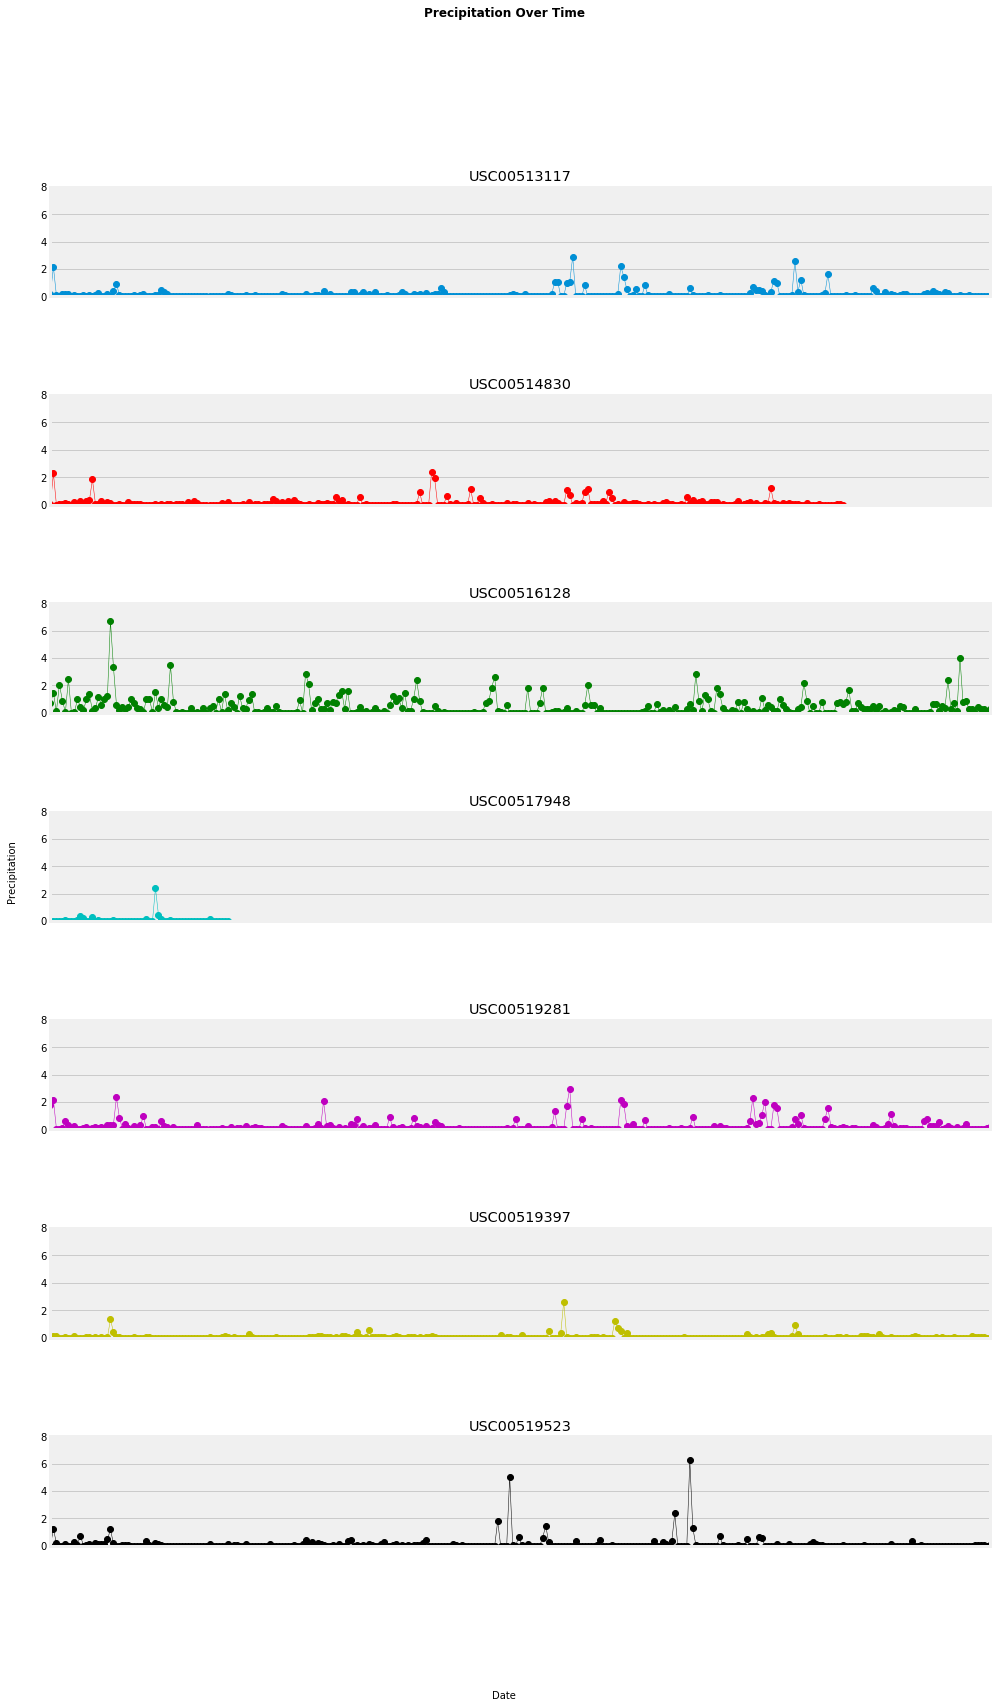

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data, 
#use subplots to plot precipitation by date for the 7 stations that had data in the time range 08/23/16 to 08/23/17

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, sharex=True, sharey=True, figsize=(15,25))
plt.subplots_adjust(hspace=0.9)
linewidth=0.5

ax1.plot(d0['Date'], d0['Precipitation'], linewidth=linewidth, marker="o")
ax1.set_title('USC00513117') 
ax1.set_xlim(min(df_meas2['Date']), max(df_meas2['Date']))
# ax1.grid(color='r', linestyle='-', linewidth=0.3)

ax2.plot(d1['Date'], d1['Precipitation'], linewidth=linewidth, marker="o", color="r")
ax2.set_title('USC00514830')
ax2.set_xlim(min(df_meas2['Date']), max(df_meas2['Date']))

ax3.plot(d2['Date'], d2['Precipitation'], linewidth=linewidth, marker="o", color="g")
ax3.set_title('USC00516128')
ax3.set_xlim(min(df_meas2['Date']), max(df_meas2['Date']))

ax4.plot(d3['Date'], d3['Precipitation'], linewidth=linewidth, marker="o", color="c")
ax4.set_title('USC00517948')
ax4.set_xlim(min(df_meas2['Date']), max(df_meas2['Date']))

ax5.plot(d4['Date'], d4['Precipitation'], linewidth=linewidth, marker="o", color="m")
ax5.set_title('USC00519281')
ax5.set_xlim(min(df_meas2['Date']), max(df_meas2['Date']))

ax6.plot(d5['Date'], d5['Precipitation'], linewidth=linewidth, marker="o", color="y")
ax6.set_title('USC00519397')
ax6.set_xlim(min(df_meas2['Date']), max(df_meas2['Date']))

ax7.plot(d6['Date'], d6['Precipitation'], linewidth=linewidth, marker="o", color="k")
ax7.set_title('USC00519523')
ax7.set_xticks([])
ax7.set_xlim(min(df_meas2['Date']), max(df_meas2['Date']))
ax7.set_ylim(bottom=0, top=8)
ax7.set_yticks(ticks=[0,2,4,6,8])


fig.suptitle("Precipitation Over Time", fontweight="bold")
fig.text(0.5, 0.04, 'Date', ha='center')
fig.text(0.04, 0.5, 'Precipitation', va='center', rotation='vertical')


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_meas.describe()
#or
df_meas2.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [16]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(Station).count()
station_count
# or
# station_count2=engine.execute('SELECT count(station) FROM station').fetchall()
# station_count2

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station=session.query(Measurement.station, 
                             func.count(Measurement.station)).\
                            group_by(Measurement.station).\
                            order_by(func.count(Measurement.station).desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_act_station=session.query(func.min(Measurement.tobs),
                               func.max(Measurement.tobs),
                               func.avg(Measurement.tobs)).\
                                filter_by(station='USC00519281').all()
temp_act_station

[(54.0, 85.0, 71.66378066378067)]

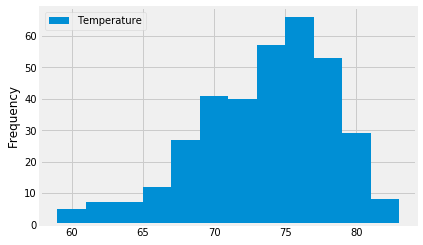

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_12mths=session.query(Measurement.tobs).filter_by(station='USC00519281').\
                                    filter(Measurement.date.between(str(date_from), str(last_date))).\
                                    order_by(Measurement.date.asc()).all() 
active_station_df=pd.DataFrame(active_station_12mths, columns=['Temperature'])
plt.hist(active_station_df['Temperature'], bins=12, label="Temperature")
plt.ylabel('Frequency')
plt.legend()

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip=calc_temps('2016-02-28', '2017-02-28')
my_trip

[(59.0, 74.14365832614322, 84.0)]

Text(0.5,1,'Trip Avg Temp')

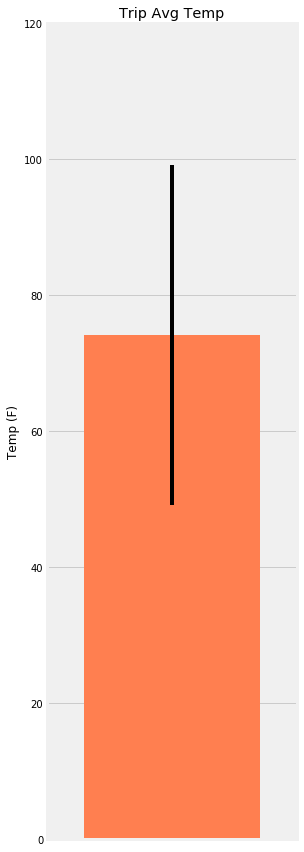

In [22]:
# Plot the results from your previous query as a bar chart. 

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y_error=my_trip[0][2]- my_trip[0][0]
y_error

# Use the average temperature for the y value
plt.figure(figsize=(4,15))
plt.bar(1,my_trip[0][1], yerr=y_error,color='coral', width=0.7)
plt.xlim(0.5,1.5)
plt.ylim(0,120)
plt.xticks([])
plt.ylabel('Temp (F)')

# Use "Trip Avg Temp" as your Title
plt.title('Trip Avg Temp')


In [23]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_rainfall=session.query(Measurement, Station).filter(Station.station==Measurement.station).all()

trip_rainfall=session.query(func.sum(Measurement.prcp),
                            Station.station,
                            Station.name,
                            Station.latitude,
                            Station.longitude,
                            Station.elevation).\
                            join(Station, Measurement.station==Station.station).\
                            group_by(Measurement.station).\
                            filter(Measurement.date.between('2016-02-28', '2017-02-28')).\
                            order_by(func.sum(Measurement.prcp).desc()).all()

trip_rainfall_df=pd.DataFrame(trip_rainfall, columns=['Total Prcp',
                                                      'Sation',
                                                      'Name',
                                                      'Latitude',
                                                      'Longitude', 
                                                      'Elevation'])

trip_rainfall_df

,Total Prcp,Sation,Name,Latitude,Longitude,Elevation
0,170.35,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,84.71,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,58.26,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,37.69,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,31.17,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,19.39,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,3.19,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")[0]

(62.0, 69.15384615384616, 77.0)

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date=dt.date(2016, 3, 1)
end_date=dt.date(2016, 3, 10)

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings

date_delta=dt.timedelta(1)
date_list_str=[]
date_list=[]

date=start_date
while date<=end_date:
    date_list_str.append(date.strftime('%m-%d'))
    date_list.append(date)
    date=date+date_delta

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals_list=[]
for date in date_list_str:
    daily_normals_list.append(daily_normals(date)[0])
    
daily_normals_list

[(64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0),
 (60.0, 69.20338983050847, 76.0),
 (60.0, 69.17241379310344, 78.0),
 (59.0, 68.72413793103448, 78.0),
 (57.0, 68.56140350877193, 75.0),
 (57.0, 69.12280701754386, 75.0)]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normals=pd.DataFrame(daily_normals_list, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
trip_normals['Date']=date_list
trip_normals.set_index('Date', drop=True, inplace=True)
trip_normals

,Min Temp,Avg Temp,Max Temp
Date,,,
2016-03-01,64.0,70.032787,76.0
2016-03-02,61.0,70.366667,78.0
2016-03-03,60.0,70.068966,78.0
2016-03-04,57.0,69.272727,77.0
2016-03-05,60.0,67.890909,76.0
2016-03-06,60.0,69.203390,76.0
2016-03-07,60.0,69.172414,78.0
2016-03-08,59.0,68.724138,78.0
2016-03-09,57.0,68.561404,75.0


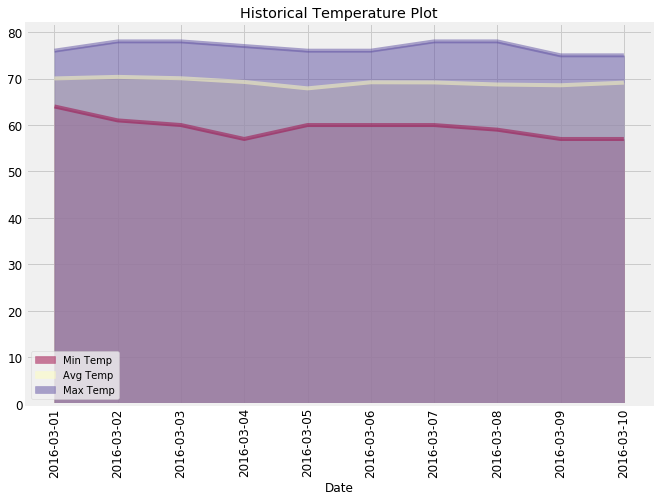

In [27]:
# Plot the daily normals as an area plot with `stacked=False`

trip_normals.plot(kind='area',
                  stacked=False,
                  alpha=0.5,
                  colormap='Spectral',
                  title='Historical Temperature Plot',
                  figsize=(10,7),
                  use_index=True,
                  rot=90,
                  fontsize=12)
